# Network summary

- Number of nodes and edges.
- Diameter, radius.
- Clustering coefficient (global, average local, histogram).
- Average path length (histogram).
- Degree distribution, fitted models by regression/MLE/KS-test.
- Gorgeous network layout. 

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
import scipy.stats
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()

In [2]:
uG = nx.read_gexf("undirected_graph.gexf")
G = nx.read_gexf("directed_graph.gexf")

## Number of nodes and edges

In [3]:
print("Nodes:", len(uG))
print("Edges:", len(uG.edges))

Nodes: 374
Edges: 1099


## Diameter, radius

In [4]:
print("Radius: ", nx.radius(uG))  # минимальный эксцентриситет
print("Diameter: ", nx.diameter(uG))  # максимальный эксцентриситет

Radius:  4
Diameter:  7


## Clustering coefficient (global, average local, histogram)

In [5]:
print("Global Clustering coefficient: ", nx.algorithms.cluster.transitivity(uG))
print("Average local Clustering coefficient: ", nx.average_clustering(uG))

Global Clustering coefficient:  0.04516078184110971
Average local Clustering coefficient:  0.1303214240157394


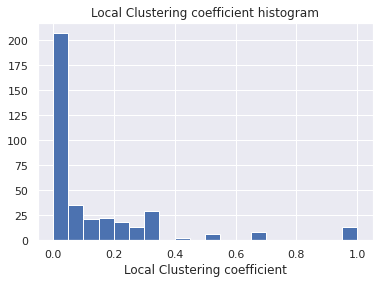

In [6]:
plt.hist(nx.clustering(uG).values(), bins=20)
plt.title("Local Clustering coefficient histogram")
plt.xlabel("Local Clustering coefficient")
plt.show()

Коэффициент кластеризации низкий (доля от всех возможных треугольников в графе)

Большое кол-во нод имеют нулевой коэффициент кластеризации - это означает, что они не входят в треугольники (в некоторых частях график близок к графу-звезде)

## Average path length (histogram)

In [7]:
print("Average path length: ", nx.average_shortest_path_length(uG))

Average path length:  2.958652922538745


In [8]:
lengths = np.ravel([list(x[1].values())[1:] for x in nx.shortest_path_length(uG)])
c = Counter(lengths)

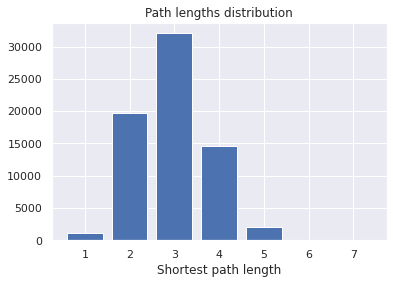

In [9]:
plt.bar(c.keys(), np.array(list(c.values())) / 2)
plt.title("Path lengths distribution")
plt.xlabel("Shortest path length")
plt.show()

Средний кратчайший путь в графе достаточно низкий

## Degree distribution, fitted models by regression/MLE/KS-test

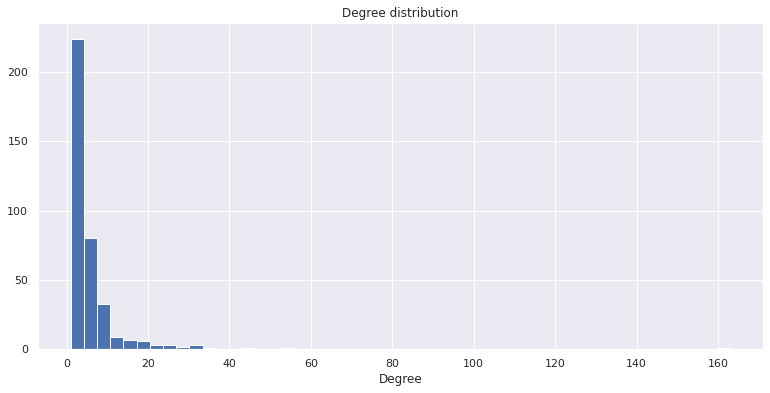

In [10]:
degrees = np.array(uG.degree)[:, 1].astype(int)
plt.figure(figsize=(13, 6))
plt.hist(degrees, bins=50)
plt.title("Degree distribution")
plt.xlabel("Degree")
plt.show()

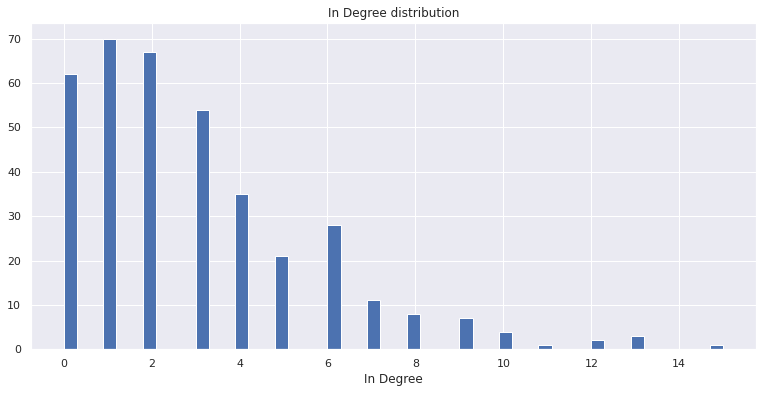

In [11]:
in_degrees = np.array(G.in_degree)[:, 1].astype(int)
plt.figure(figsize=(13, 6))
plt.hist(in_degrees, bins=50)
plt.title("In Degree distribution")
plt.xlabel("In Degree")
plt.show()

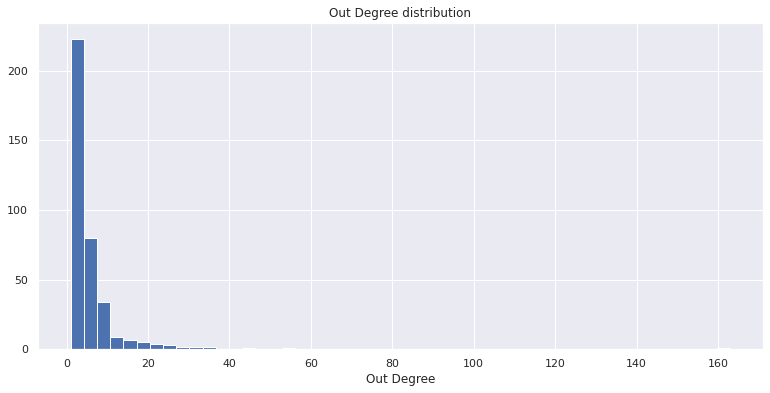

In [12]:
out_degrees = np.array(G.degree)[:, 1].astype(int)
plt.figure(figsize=(13, 6))
plt.hist(out_degrees, bins=50)
plt.title("Out Degree distribution")
plt.xlabel("Out Degree")
plt.show()

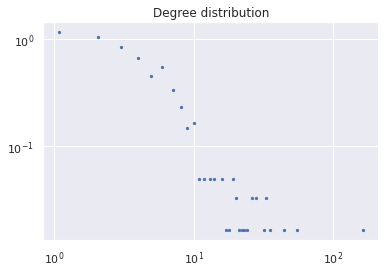

In [13]:
hist, bin_edges = np.histogram(degrees, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title("Degree distribution")
plt.xscale("log")
plt.yscale("log")

In [14]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    return (1 - r) ** (1 / (-alpha + 1)) * x_min

In [15]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

In [16]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    return 1 - x ** (-alpha + 1) / x_min ** (-alpha + 1)

In [17]:
x_min = 1

hist, bin_edges = np.histogram(degrees[degrees >= x_min], bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

lr = LinearRegression()
lr.fit(np.log(bin_centers[hist != 0]).reshape(-1, 1), np.log(hist[hist != 0]))

lr.coef_

array([-1.33224985])

In [18]:
alpha = -lr.coef_
x_space = np.linspace(x_min, 160, 100)

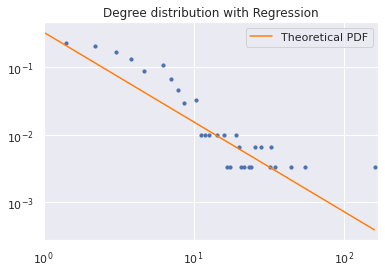

In [19]:
hist, bin_edges = np.histogram(degrees, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), label="Theoretical PDF", c="tab:orange")
plt.title("Degree distribution with Regression")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(x_min, 170)
plt.show()

In [20]:
def mle_power_law_params(degree_sequence):
    alpha = None
    x_min = None
    ks = None
    for x_min_ in np.linspace(degree_sequence.min(), degree_sequence.max(), 100):
        degree_sequence_ = degree_sequence[degree_sequence >= x_min_]
        alpha_ = 1 + len(degree_sequence_) / np.sum(np.log(degree_sequence_ / x_min_))
        ks_ = scipy.stats.kstest(degree_sequence_, lambda x: power_law_cdf(x, alpha=alpha_, x_min=x_min_))[0]
        if ks is None or ks > ks_:
            alpha = alpha_
            x_min = x_min_
            ks = ks_
    return alpha, x_min

/tmp/ipykernel_1770/316295202.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_ = 1 + len(degree_sequence_) / np.sum(np.log(degree_sequence_ / x_min_))
/tmp/ipykernel_1770/260356965.py:2: RuntimeWarning: invalid value encountered in true_divide
  return 1 - x ** (-alpha + 1) / x_min ** (-alpha + 1)


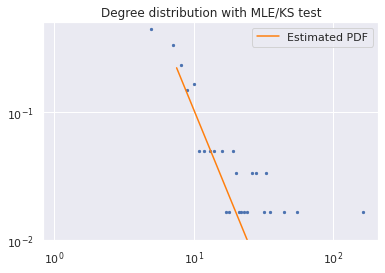

In [21]:
hist, bin_edges = np.histogram(degrees, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title("Degree distribution with MLE/KS test")

hat_alpha, hat_x_min = mle_power_law_params(degrees)
x_space = np.linspace(hat_x_min, degrees.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), label="Estimated PDF", c="tab:orange")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.01, 0.5);

Можно сказать, что распределение степеней вершин похоже на степенной закон (в графе небольшое количество вершин имеет большую степень)

## Gorgeous network layout

In [22]:
import ipyplot

ipyplot.plot_images(
    ["ods_graph.svg"],
    img_width=1000,
    # force_b64=True
)

Цвет узла на графе показывает принадлежность к компании, цвет связи показывает оттенок реакции (красный - негативный, зеленый - положительный), размер ноды определяется по in_degree

По визуализации графа видно, что граф достаточно плотно связан, сложно выделить группы. Также можно отметить, что компании не обязательно тесно связаны в графе (не обязательно сотрудники одной компании ставят реакции друг другу). Видно, что нода, поставившая наибольшее кол-во реакций (расположена в центре графа) - ставит в основном негативные реакции.